In [12]:
%matplotlib inline
import math
import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
iris = sklearn.datasets.load_iris()
X = iris.data
y = iris.target

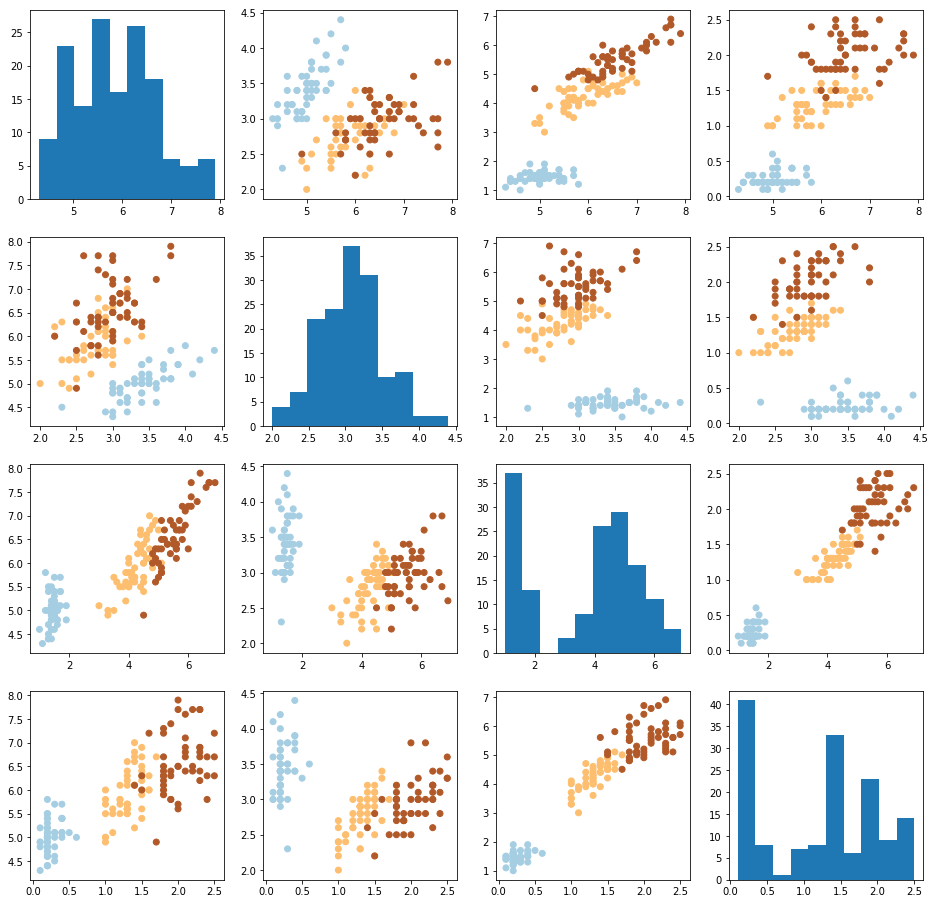

In [13]:
def myplotGrid(X,y):
    nf = X.shape[1] # number of features
    fig = plt.figure(figsize=(16,16))
    index = 0
    for a in range(nf):
        for b in range(nf):
            index += 1
            if a == b:
                ax = fig.add_subplot(nf,nf,index)
                ax.hist(X[:, a])
            else:
                ax = fig.add_subplot(nf,nf,index)
                ax.scatter(X[:, a], X[:, b], c=y, cmap=plt.cm.Paired)
myplotGrid(X, y)

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings (e.g., from webcams or other errors) they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,


    np.random.seed(mySeed) # initialize random seed to replicate results over different runs
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)

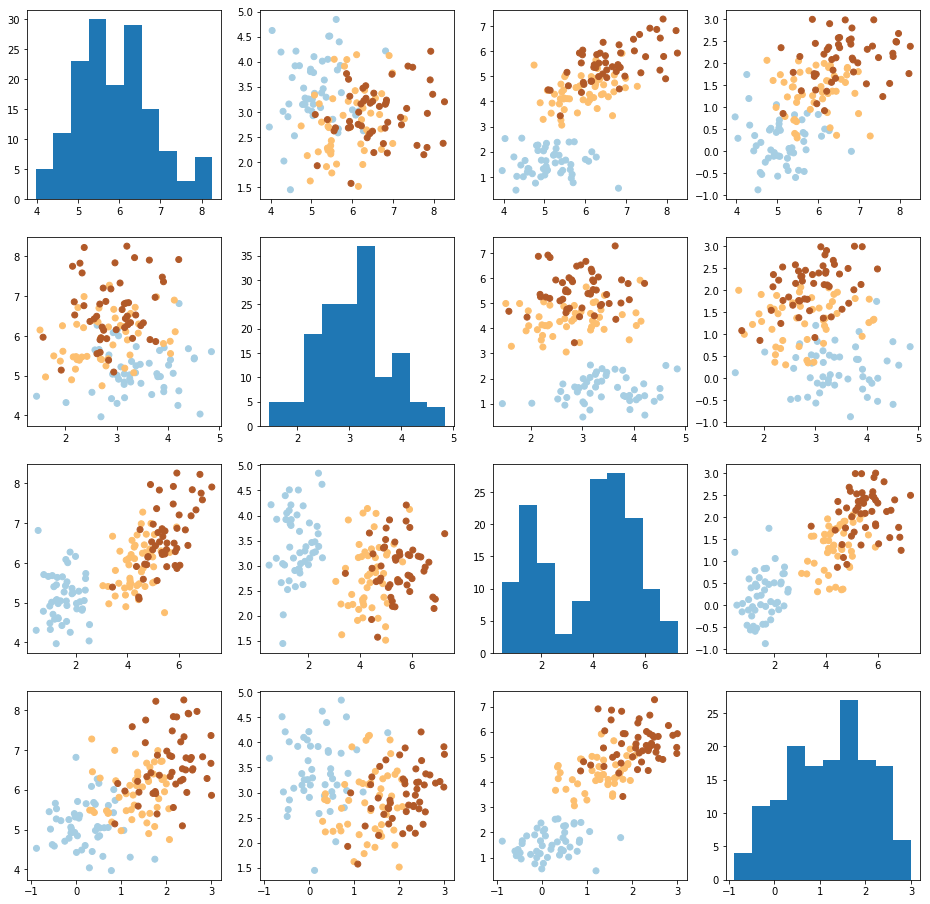

In [14]:
mySeed = 1234567
np.random.seed(mySeed)
XN = X + np.random.normal(0, 0.5, X.shape)
myplotGrid(XN, y)

## 2. Implementing kNN

In the cell below, develop your own code for performing k-Nearest Neighbour classification. Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

### Distance functions (euclidean and manhattan)
These two simple functions are faster than those coming from large scientific packages.
To read more about it: https://stackoverflow.com/a/37795190

In [15]:
def manhattanDistance(in1, in2):
    sum = 0
    for x, y in zip(in1, in2):
        sum += abs(x - y)
    return sum

In [16]:
def euclideanDistance(in1, in2):
    sum = 0
    for x, y in zip(in1, in2): 
        sum += (x-y)**2
    return math.sqrt(sum)

In [17]:
def confusionMatrix(targets, predicted):
    nc = len(np.unique(targets)) # number of classes 
    mdim = (nc, nc) # matrix dimensions
    conf = np.zeros(mdim)# initialize to all zeros

    for x, y in zip(targets, predicted):
        conf[x][y] += 1

    return conf

In [18]:
def getNeighbours(x_, X, n, T, d):
    if d == "manhattan":
        dists = [manhattanDistance(x_, it) for it in X]
        neighbours = np.array(dists).argsort()
        return neighbours[:n]

    elif d == "euclidean":
        dists = [euclideanDistance(x_, it) for it in X]
        neighbours = np.array(dists).argsort()
        return neighbours[:n]
    else:
        return 0

In [19]:
def assignLabel(neighbours, targets):
    votes = {}
    for x in neighbours:
        if targets[x] in votes:
            votes[targets[x]] += 1
        else:
            votes[targets[x]] = 1
    return max(votes, key = votes.get)

In [20]:
def myAccuracy(y_test, y_pred):
    a = len(np.where(y_test == y_pred)[0])
    accuracy = (a / len(y_test)) * 100
    return accuracy

Oh, I'm proud of that function. myKNN in three lines of code. Pretty, isn't it?

In [21]:
def myKNN(X, y, X_, options):
    neighbours = [getNeighbours(it, X, options[0], X.shape[0], options[1]) for it in X_]
    predicted = [assignLabel(it, y) for it in neighbours]
    return predicted

## 3. Nested Cross-validation using your implementation of KNN

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above.  Again, you are guided to complete this task by following the appropriate notebook in Lab 4.  Your code for nested cross-validation should invoke your kNN function (see above).  You cross validation function should be invoked similary to:

    accuracy_fold=myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan']`` evaluates the two distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should implement/validate at least two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each fold, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [22]:
def myNCV(training, target, folds, neighbours, dists, mySeed):
    accuracy_fold = []
    np.random.seed(mySeed)
    L = list(range(training.shape[0]))
    
    # Shuffle indices of the training data (iris.data)
    indices = np.random.permutation(L) 
    
    # Split the data into *folds* bins. 
    # You can play with that param as well, 
    # underneath that func, there is a variable called "options", 
    # that takes numer of folds as a parameter
    bins = np.array_split(indices, folds)
    
    conf_matrices = [] # list to store confMatrices for each fold, 
                       # to sum them up (element-wise) in the end
    
    for i in range(folds):
        foldTrain = []
        foldTest = []
        foldVal = []
        
        # Splitting into training and test bins, damn that took me ages to make it fast and neat
        # bwt - bins without test_bin
        bwt = bins[:i] + bins[(i + 1):]
        foldTrain = [item for sublist in bwt for item in sublist]
        
        # we're going to use that foldTest to evaluate performance of our classifier
        foldTest = bins[i].tolist() 
        
        # Then, we repeat the procedure of splitting into k-Folds, 
        # to leave one for validation and the rest for training
        tr_bins = np.array_split(foldTrain, folds)
        
        for j in range(len(bins)):
            foldTrain = []
            bwv = tr_bins[:j] + tr_bins[(j+1):]
            foldTrain = [item for sublist in bwv for item in sublist]
            foldVal = tr_bins[j].tolist()
        bestDistance = ''
        bestNN = -1
        bestAccuracy = -10
        
        # Great, at this point we have:
        # foldTest of length = 30, 
        # foldVal of length = 24
        # foldTrain of length = 96
   
        # We want to iterate through:
        # each distance passed as a parameter to myNCV (neighbours),
        # each number of neighbours passed as a param to myNCV (dists).
        
        # Why do we do that?
        # Because we want to find the best setting for each fold, 
        # taking into account only validation set
        
        for distance in dists:
            for nn in neighbours:
                val_pred = myKNN(training[foldTrain], target[foldTrain], training[foldVal], [nn, distance])
                acc = myAccuracy(target[foldVal], val_pred)
                if acc > bestAccuracy:
                    bestDistance = distance
                    bestNN = nn
                    bestAccuracy = acc
         
        # Once we're done with validation set, we can append it to our foldTrain array.
        foldTrain = foldTrain + foldVal 
        
        # here, we're making predictions for *i* fold.
        y_pred = myKNN(training[foldTrain], target[foldTrain], training[foldTest], [bestNN, bestDistance])
        
        # Measure accuracy on *i* fold (trueValues, predicted)
        acc = myAccuracy(target[foldTest], y_pred)
        
        # Not much to explain here
        confusionMat = confusionMatrix(target[foldTest], y_pred)
        
        
        print("Fold ", i,": Accuracy = ", acc, "; N: ", bestNN, "; D: ", bestDistance)
        print(confusionMat)
        
        accuracy_fold.append(acc)
        conf_matrices.append(confusionMat)
    
        
        
    # That ugly code adds up all the matrices from k folds to produce the final confusion matrix.   
    som = np.zeros(conf_matrices[0].shape)
    for x in range(0, len(conf_matrices)):
        som += conf_matrices[x]
        
    print("\nFinal confusion matrix for k folds: \n")
    print(som) 
        
    return accuracy_fold

In [23]:
options = [list(range(1,11)), ["euclidean", "manhattan"], 5]

In [24]:
cleanData = myNCV(X, y, options[2], options[0], options[1], mySeed)
print(np.std(cleanData))

Fold  0 : Accuracy =  96.66666666666667 ; N:  5 ; D:  euclidean
[[11.  0.  0.]
 [ 0. 10.  1.]
 [ 0.  0.  8.]]
Fold  1 : Accuracy =  93.33333333333333 ; N:  5 ; D:  euclidean
[[12.  0.  0.]
 [ 0. 11.  0.]
 [ 0.  2.  5.]]
Fold  2 : Accuracy =  93.33333333333333 ; N:  1 ; D:  euclidean
[[ 5.  0.  0.]
 [ 0. 13.  1.]
 [ 0.  1. 10.]]
Fold  3 : Accuracy =  100.0 ; N:  5 ; D:  euclidean
[[11.  0.  0.]
 [ 0.  7.  0.]
 [ 0.  0. 12.]]
Fold  4 : Accuracy =  96.66666666666667 ; N:  1 ; D:  euclidean
[[11.  0.  0.]
 [ 0.  6.  1.]
 [ 0.  0. 12.]]

Final confusion matrix for k folds: 

[[50.  0.  0.]
 [ 0. 47.  3.]
 [ 0.  3. 47.]]
2.4944382578492967


In [25]:
noisyData = myNCV(XN, y, options[2], options[0], options[1], mySeed)
print(np.std(noisyData))

Fold  0 : Accuracy =  80.0 ; N:  5 ; D:  euclidean
[[11.  0.  0.]
 [ 0.  8.  3.]
 [ 0.  3.  5.]]
Fold  1 : Accuracy =  83.33333333333334 ; N:  7 ; D:  euclidean
[[12.  0.  0.]
 [ 0.  9.  2.]
 [ 0.  3.  4.]]
Fold  2 : Accuracy =  90.0 ; N:  9 ; D:  manhattan
[[ 5.  0.  0.]
 [ 0. 12.  2.]
 [ 0.  1. 10.]]
Fold  3 : Accuracy =  100.0 ; N:  5 ; D:  euclidean
[[11.  0.  0.]
 [ 0.  7.  0.]
 [ 0.  0. 12.]]
Fold  4 : Accuracy =  73.33333333333333 ; N:  1 ; D:  euclidean
[[11.  0.  0.]
 [ 0.  4.  3.]
 [ 0.  5.  7.]]

Final confusion matrix for k folds: 

[[50.  0.  0.]
 [ 0. 40. 10.]
 [ 0. 12. 38.]]
9.092121131323903
